# Predicting sale price of bulldozers using Machine Learning

**Data:**

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

   * Train.csv is the training set, which contains data through the end of 2011.
   * Valid.csv is the validation set, which contains data from January 1, 2012 - April 30,      2012 You make predictions on this set throughout the majority of the competition. Your      score on this set is used to create the public leaderboard.
   * Test.csv is the test set, which won't be released until the last week of the     
     competition. It contains data from May 1, 2012 - November 2012. Your score on the test      set determines your final rank for the competition.
     
**Data Dictionary**

Information about the dataset:

https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit#gid=1021421956
     
**Evaluation:**
   * The evaluation metrics used here is the RMSLE (root mean squared log error) between        the actual and predicted auction prices.
     
     More regarding evaluation of this specific project can be found here:
     https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

%matplotlib inline

In [2]:
bp = pd.read_csv("data/TrainAndValid.csv",
                 low_memory=False)

In [3]:
bp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

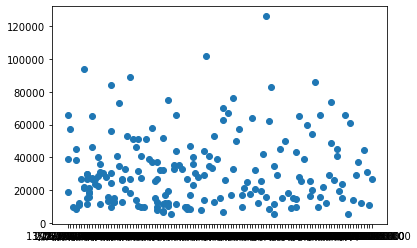

In [4]:
fig, ax = plt.subplots()
ax.scatter(bp["saledate"][:200], bp["SalePrice"][:200])#Since its a time-series problem,
                                                          #i have decide to compare saledate and saleprice

In [5]:
bp.saledate.dtype

dtype('O')

### Parsing Date
 
As we are working with time series data, we would like to enrich our time and date component as much as possible. We can accomplish that by using the `parse_dates` parameter

In [6]:
bp = pd.read_csv("data/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [7]:
bp.saledate.dtype

dtype('<M8[ns]')

In [8]:
bp.saledate[:10]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

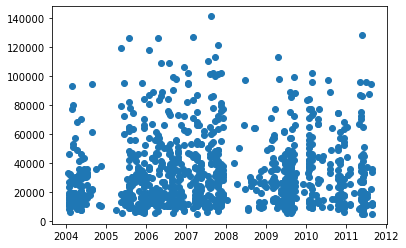

In [9]:
fig, ax = plt.subplots()
ax.scatter(bp["saledate"][:1000], bp["SalePrice"][:1000])

### Sorting Dataframe by saledate in ascending order

In [10]:
bp.sort_values(by=["saledate"],
               inplace=True,
               ascending=True)
bp.saledate[:10]

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]

In [11]:
#Making a copy of the dataframe so the original dateframe remains intact
bp_tmp = bp.copy()

In [12]:
bp_tmp.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [13]:
bp_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [14]:
#Adding datetime parameters for saledate column
bp_tmp["saleYear"] = bp_tmp.saledate.dt.year
bp_tmp["saleMonth"] = bp_tmp.saledate.dt.month
bp_tmp["saleDay"] = bp_tmp.saledate.dt.day
bp_tmp["saleDayOfWeek"] = bp_tmp.saledate.dt.dayofweek
bp_tmp["saleDayOfYear"] = bp_tmp.saledate.dt.dayofyear


In [15]:
bp_tmp.drop("saledate",
             axis=1,
             inplace=True)

### Converting string to pandas categories

In [16]:
pd.api.types.is_string_dtype(bp_tmp["Transmission"])

True

In [17]:
# Finding the columns which contain strings
for column, values in bp_tmp.items():
    if pd.api.types.is_string_dtype(values):
        print(column)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [18]:
#Converting all the string value into category values
for column, values in bp_tmp.items():
    if pd.api.types.is_string_dtype(values):
        bp_tmp[column] = values.astype("category").cat.as_ordered()

In [19]:
bp_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [20]:
bp_tmp.Transmission.cat.categories

Index(['AutoShift', 'Autoshift', 'Direct Drive', 'Hydrostatic',
       'None or Unspecified', 'Powershift', 'Powershuttle', 'Standard'],
      dtype='object')

In [21]:
bp_tmp.Transmission.cat.codes

205615    2
274835   -1
141296    7
212552   -1
62755     7
         ..
410879    7
412476   -1
411927   -1
407124    4
409203   -1
Length: 412698, dtype: int8

In [22]:
bp_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Filling missing values

In [23]:
#Filling numeric values
for column, values in bp_tmp.items():
    if pd.api.types.is_numeric_dtype(values):
        print(column)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [24]:
#Checking for null values
for column, values in bp_tmp.items():
    if pd.api.types.is_numeric_dtype(values):
        if pd.isnull(values).sum():
         print(column)

auctioneerID
MachineHoursCurrentMeter


In [25]:
#Filling missing numeric values with median
for column, values in bp_tmp.items():
    if pd.api.types.is_numeric_dtype(values):
        if pd.isnull(values).sum():
            # Add a binary column which tells us if the data was missing or not
            bp_tmp[column+"_is_missing"] = pd.isnull(values)
            bp_tmp[column] = values.fillna(values.median())

In [26]:
for column, values in bp_tmp.items():
    if pd.api.types.is_numeric_dtype(values):
        if pd.isnull(values).sum():
         print(column)

In [27]:
bp_tmp.MachineHoursCurrentMeter_is_missing.value_counts()

True     265194
False    147504
Name: MachineHoursCurrentMeter_is_missing, dtype: int64

In [28]:
#Converting categorical values into numbers
#First check for the categorocal values
for column, values in bp_tmp.items():
    if not pd.api.types.is_numeric_dtype(values):
        print(column)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [29]:
#Convertinf cat values into numbers 
for column, values in bp_tmp.items():
    if not pd.api.types.is_numeric_dtype(values):
        # Adding a binary column to inidicate whether sample had missing value
        bp_tmp[column+"_is_missing"] = pd.isnull(values)
        bp_tmp[column] = pd.Categorical(values).codes+1

In [30]:
bp_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

### Modelling

In [31]:
# %%time
# from sklearn.ensemble import RandomForestRegressor

# x = bp_tmp.drop("SalePrice", axis=1)
# y = bp_tmp["SalePrice"]

# model = RandomForestRegressor(n_jobs=-1,
#                               random_state=42)

# model.fit(x,y)

In [32]:
# model.score(x,y)

In [36]:
bp_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [37]:
# Splitting data into training and validation
bp_val = bp_tmp[bp_tmp.saleYear == 2012]
bp_train = bp_tmp[bp_tmp.saleYear != 2012]

len(bp_val), len(bp_train)

(11573, 401125)

In [38]:
#Splitting into x and y labels
x_train = bp_train.drop("SalePrice", axis=1)
y_train = bp_train.SalePrice
x_valid = bp_val.drop("SalePrice", axis=1)
y_valid = bp_val.SalePrice

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((401125, 102), (11573, 102), (401125,), (11573,))

### Creating the evaluation function

In [39]:
#Creating the evaluation metric(RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

#Evaluation function:
def show_scores(model):
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(x_train, y_train),
              "Valid R^2": model.score(x_valid, y_valid)}
    return scores

### Testing the model on a sebset of the data for hyperparameter tuning(as it takes too long to test on the entire data set)

In [41]:
#Fitting the data to a truncated dataset
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)



In [42]:
%%time
model.fit(x_train,y_train)

Wall time: 14.5 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [43]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

In [44]:
model

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

### Hyperparameter tuning using RandomizedSearchCV

In [49]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rscv_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=4,
                              cv=5,
                              verbose=True)

rscv_model.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Wall time: 2min 8s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=4,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [50]:
rscv_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 6,
 'min_samples_leaf': 15,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': 5}

In [51]:
show_scores(rscv_model)

{'Training MAE': 9807.768631932353,
 'Valid MAE': 11247.944519752233,
 'Training RMSLE': 0.4223687943162441,
 'Valid RMSLE': 0.4381204095543492,
 'Training R^2': 0.6239516090200226,
 'Valid R^2': 0.6365883342027143}

In [52]:
%%time
#Found ideal estimator parameter values through research as it would take way too long for my machine to compute 
new_model = RandomForestRegressor(n_estimators=40,
                                  min_samples_leaf=1,
                                  min_samples_split=14,
                                  max_features=0.5,
                                  n_jobs=-1,
                                  max_samples=None,
                                  random_state=42)

new_model.fit(x_train, y_train)

Wall time: 53.9 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [53]:
#Here we can see that the Valid RMSLE value has gone down significantly as we want to rediuce error on our model
show_scores(new_model)

{'Training MAE': 2952.4648881206103,
 'Valid MAE': 5938.109715467803,
 'Training RMSLE': 0.14457076705804228,
 'Valid RMSLE': 0.24564484529691025,
 'Training R^2': 0.9589468816160461,
 'Valid R^2': 0.8828132099105394}

### Making predictions on the test data

In [107]:
#Importing test data
bp_test = pd.read_csv("data/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])
bp_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Getting the test dataset and train dataset in the same format


In [108]:
df = pd.read_csv("data/TrainAndValid.csv")

F:\ML-Project\end-to-end-project\env\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [109]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

In [110]:
bp_test = preprocess_data(bp_test)


In [112]:
bp_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [114]:
x_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [115]:
set(x_train.columns) - set(bp_test.columns)

{'auctioneerID_is_missing', 'saleDayOfWeek', 'saleDayOfYear'}

In [116]:
bp_test["auctioneerID_is_missing"] = False
bp_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [117]:
test_preds = new_model.predict(bp_test)

In [118]:
len(test_preds)

12457